# Calibration Sorgho Mali
Ce notebook a pour objectif de réaliser une preuve de concept de calibration semi-automatique du modèle SARRA.

Il est basé sur les données du projet AgrECO Mali fournies par Michel VAKSMANN.

# Imports

In [62]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io
from datetime import datetime as dt
from sklearn.metrics import r2_score, mean_squared_error

sys.path.append("../../src/")
from sarra_py import *

# Chargement des données observées

In [76]:
# chargement des données
observations_full = pd.read_csv("/mnt/g/Mon Drive/CIRAD/AgrEco sorgho/observations.csv",sep=";")
# on ne conserve qu'une seule variété pour un premier exemple
observations_full = observations_full[observations_full["NOMVAR"]=="CS20-14"].reset_index(drop=True)
#observations_full = observations_full[observations_full["NOMVAR"]=="TdC"].reset_index(drop=True)
observations_full["DATE_SEM"] = observations_full.apply(lambda x: datetime.datetime.strptime(x["DATE_SEM"], "%d/%m/%Y").date(), axis=1)
observations_full["DATE"] = observations_full.apply(lambda x: datetime.datetime.strptime(x["DATE"], "%d/%m/%Y").date(), axis=1)
observations_full["DAS"] = observations_full.apply(lambda x: (x["DATE"] - x["DATE_SEM"]).days, axis=1)

In [77]:
observations_full

,SEM,DATE_SEM,NUMVAR,NOMVAR,BLOC,DATE,NbBM/m²,NbTal/m²,Tig/m²,TIG,...,TIGTal/m²,FEUbm/m²,FEUTal/m²,PANbm/m²,PANTal/m²,LIG,NbETN,biomasseFeuilles,biomasseAerienne,DAS
0,1,2021-06-21,1,CS20-14,1,2021-10-12,"5,333333333","1,066666667","6,4","672,6672664",...,"15,80956298","211,1382382","7,512121625","65,65623284",0,36,"24,75","218,6503598","956,973859",113
1,1,2021-06-21,1,CS20-14,1,2021-07-27,"5,333333333",0,"5,333333333","25,49885851",...,0,"42,24409394",0,0,0,"12,25","7,75","42,24409394","67,74295245",36
2,1,2021-06-21,1,CS20-14,1,2021-08-20,"5,333333333",0,"5,333333333","130,0905023",...,0,"140,1118206",0,0,0,"20,75","15,25","140,1118206","270,2023229",60
3,1,2021-06-21,1,CS20-14,1,2021-11-11,"5,333333333","1,066666667","6,4","593,141386",...,"69,17344754","70,63703704","12,8671161","12,84974093","89,74482158",36,"21,75","83,50415314","779,2401016",143
4,1,2021-06-21,1,CS20-14,2,2021-10-12,"5,333333333","3,2","8,533333333","628,3174337",...,"111,4328021","189,5303409","51,81516678","29,79901153",0,34,"24,75","241,3455076","899,4619529",113
5,1,2021-06-21,1,CS20-14,2,2021-07-27,"5,333333333","2,133333333","7,466666667","4,855011447",...,"0,096603774","12,67101297","0,120430108",0,0,"11,5","4,25","12,79144308","17,64645452",36
6,1,2021-06-21,1,CS20-14,2,2021-08-20,"5,333333333","3,2","8,533333333","173,3777457",...,"50,44621238","134,8464851","51,05378531",0,0,19,"14,75","185,9002705","359,2780162",60
7,1,2021-06-21,1,CS20-14,2,2021-11-11,"5,333333333","1,066666667","6,4","559,816711",...,"9,04496788","48,58790542","2,388214732","107,0259067",0,34,"20,5","50,97612015","717,8187378",143
8,1,2021-06-21,1,CS20-14,3,2021-10-12,"5,333333333",0,"5,333333333","600,6702827",...,0,"180,8996901",0,"53,78583196",0,"35,5","24,75","180,8996901","835,3558048",113
9,1,2021-06-21,1,CS20-14,3,2021-07-27,"5,333333333","2,133333333","7,466666667","19,18857536",...,"1,098867925","34,31363477","1,806451613",0,0,"11,75",7,"36,12008638","55,30866174",36


# Chargement des données météo observées

In [78]:
# on charge les données météo observées
df_weather = pd.read_csv("/mnt/g/Mon Drive/CIRAD/AgrEco sorgho/meteo.csv",sep=";",decimal=",")

# essai mené à Sotuba
# Latitude : 12°39’N
# Longitude : 7°56’O
# en décimal : 12.653403, -7.927809
# Altitude : 320 m
latitude = 12.653403
altitude = 320

angstA = 0.29
angstB = 0.49

df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Date"], "%d/%m/%Y").date(), axis=1)
df_weather.rename(columns={"TM":"TEMP", "PR":"RAIN", 'RG MJ/m²/j':'IRRAD'}, inplace=True)
# https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
# e = RH/100 * es
df_weather["es"] = 6.11 * 10 ** ((7.5 * df_weather["TEMP"])/(237.3 + df_weather["TEMP"]))
df_weather["VAP"] = df_weather["UM"]/100 * df_weather["es"]
df_weather["ET0"] = df_weather.apply(lambda x: reference_ET(x["Jour"], latitude, altitude, x["TN"], x["TX"], x["IRRAD"]*1E6, x["VAP"], x["VT"], angstA, angstB, ETMODEL="PM")[2],axis=1)

# culture pluviale, irrigation nulle
df_weather["irrigation"]=0

In [79]:
df_weather

,Date,TN,TX,TEMP,UN,UX,UM,RAIN,Day,Month,...,VT,Hmax,IGA,RG J/cm²/j,IRRAD,Jour,es,VAP,ET0,irrigation
0,01/01/2021,15.0,37.0,26.00,24,78,51.0,0.0,1,1,...,0.4,11.27,2953,2253,22.53,2021-01-01,33.623374,17.147921,3.979921,0
1,02/01/2021,19.5,36.5,28.00,25,45,35.0,0.0,2,1,...,1.0,11.27,2957,2256,22.56,2021-01-02,37.809239,13.233234,4.782193,0
2,03/01/2021,17.5,36.3,26.90,23,52,37.5,0.0,3,1,...,0.6,11.28,2961,2216,22.16,2021-01-03,35.454164,13.295312,4.108260,0
3,04/01/2021,20.5,37.0,28.75,19,42,30.5,0.0,4,1,...,0.8,11.28,2966,2261,22.61,2021-01-04,39.492004,12.045061,4.510258,0
4,05/01/2021,19.7,35.5,27.60,14,35,24.5,0.0,5,1,...,1.4,11.29,2971,2291,22.91,2021-01-05,36.937557,9.049701,5.347123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,20.8,32.8,26.80,17,26,21.5,0.0,27,12,...,1.4,11.26,2937,1455,14.55,2021-12-27,35.246546,7.578007,4.527204,0
361,28/12/2021,19.7,33.4,26.55,12,37,24.5,0.0,28,12,...,1.6,11.26,2940,2203,22.03,2021-12-28,34.732127,8.509371,5.364298,0
362,29/12/2021,13.7,33.5,23.60,17,64,40.5,0.0,29,12,...,1.2,11.26,2942,2245,22.45,2021-12-29,29.138156,11.800953,4.662442,0
363,30/12/2021,13.2,35.0,24.10,16,70,43.0,0.0,30,12,...,0.8,11.27,2945,2247,22.47,2021-12-30,30.026881,12.911559,4.265237,0


# Preparation du run

## Loading parameters

In [80]:
# le nombre d'échantillons correspond au nombre de répétitions indépendantes de l'expérimentation
# ici, pour une même variété, deux semis séparés ont été réalisés
num_samples = len(observations_full["DATE_SEM"].unique())

# on définit les dimensions de la matrice de simulation
grid_width = 1 # largeur de 1
grid_height = num_samples # on répartit les différents runs parallèles sur la colonne
duration = 180 # 6 mois de durée de simulation seront suffisants pour le sorgho

# date de démarrage de la simulation = date la plus précoce moins 15 jours
lag = 15
date_start = observations_full["DATE_SEM"].values.min() - datetime.timedelta(days=lag)

In [81]:
# YAML parameter filenames
file_paramVariete = "sorgho_variety.yaml"
file_paramITK = "sorgho_itk.yaml" # do not forget to override date_start
file_paramTypeSol = "sorgho_soil.yaml"

# Read YAML files
# paramVariete
with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)    
if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

# paramITK
with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)
# overriding sowing dates with the sowing dates of each of the samples
# we must take care of the order of the dates
paramITK["DateSemis"] = [observations_full.loc[observations_full["SEM"] == observations_full["SEM"].unique()[sem], "DATE_SEM"].max() for sem in range(len(observations_full["SEM"].unique()))]

# paramTypeSol
with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)
if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [82]:
paramITK["DateSemis"]

[datetime.date(2021, 6, 21), datetime.date(2021, 7, 17)]

In [83]:
# building weather dfs
# one df per sample ; here there are the same because experiments were done on the same site
df_weather_collection = {}
for sample in tqdm(range(num_samples)):
    df_weather_collection[sample] = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<date_start+datetime.timedelta(days=duration))].reset_index(drop=True)

100%|██████████| 2/2 [00:00<00:00, 742.88it/s]


## Building matrices

In [84]:
def InitSup2_alt(data, grid_width, grid_height, duration, df_weather_collection):
    data["tpMoy"] = np.concatenate([df_weather_collection[df_weather_id]["TEMP"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rain"] = np.concatenate([df_weather_collection[df_weather_id]["RAIN"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["ET0"] = np.concatenate([df_weather_collection[df_weather_id]["ET0"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rg"] = np.concatenate([df_weather_collection[df_weather_id]["IRRAD"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["irrigation"] = np.concatenate([df_weather_collection[df_weather_id]["irrigation"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    return data

In [85]:
def InitSoilReservoirs(data, grid_width, grid_height, duration):
    for param in ["ru", "epaisseurSurf", "stockIniProf", "epaisseurProf", "seuilRuiss", "pourcRuiss"] :
        data[param] = np.full((grid_width, grid_height, duration), (paramTypeSol[param]))
    return data

In [86]:
data_run = {}

# on initialise 
data_run = InitSoilReservoirs(data_run, grid_width, grid_height, duration)
data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration)
data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
data_run = InitSup(data_run, grid_width, grid_height, duration, paramTypeSol, paramITK) # penser à override l'irrigation
data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather_collection)
data_run = EvalPar(data_run)

# Run

In [87]:
import warnings
warnings.filterwarnings("ignore")

for j in tqdm(range(duration)):
    #procédure pour prendre en compte une date de semis différente par sample/pixel vertical
    data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
    data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK
    for sample in range(num_samples):
        if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
            for variable in data_run_local :
                try:
                    data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                    data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                except:
                    pass
    #bilan hydrique
    data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
    data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
    data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
    data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
    data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
    
    # phenologie
    data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    
    #phenologie
    data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
    data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2

100%|██████████| 180/180 [00:00<00:00, 490.06it/s]


In [91]:
    sim_harvest = np.where(data_run["numPhase"]==7)[2] - lag
    # we remove the lag as the matrix time series starts with a -15 days lag 
    obs_harvest = np.array([observations_full.loc[observations_full["SEM"]==observations_full["SEM"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEM"].unique()))])
    df_comparison = pd.DataFrame({"observed_harvest":obs_harvest, "sim_harvest":sim_harvest})
    rmse = mean_squared_error(df_comparison["observed_harvest"], df_comparison["sim_harvest"], squared=False)
    print("obs",obs_harvest,"sim",sim_harvest)

obs [143 125] sim [ 90 117]


# essai optim

In [94]:
import warnings
warnings.filterwarnings("ignore")

def run(SDJRPR, SDJMatu1, SDJMatu2):

    #########################################
    # YAML parameter filenames
    file_paramVariete = "sorgho_variety.yaml"
    file_paramITK = "sorgho_itk.yaml" # do not forget to override date_start
    file_paramTypeSol = "sorgho_soil.yaml"

    # Read YAML files
    # paramVariete
    with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
        paramVariete = yaml.safe_load(stream)    
    if paramVariete["feuilAeroBase"] == 0.1 :
        raise exception()

    # paramITK
    with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
        paramITK = yaml.safe_load(stream)
    # overriding sowing dates with the sowing dates of each of the samples
    # we must take care of the order of the dates
    paramITK["DateSemis"] = [observations_full.loc[observations_full["SEM"] == observations_full["SEM"].unique()[sem], "DATE_SEM"].max() for sem in range(len(observations_full["SEM"].unique()))]

    # paramTypeSol
    with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
        paramTypeSol = yaml.safe_load(stream)
    if ~np.isnan(paramITK["NI"]):
        print("NI NON NULL") 
        paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631) 


    #########################################
    # paramVariete["SDJBVP"] = SDJBVP
    paramVariete["SDJRPR"] = SDJRPR
    paramVariete["SDJMatu1"] = SDJMatu1
    paramVariete["SDJMatu2"] = SDJMatu2


    #########################################
    # building weather dfs
    # one df per sample ; here there are the same because experiments were done on the same site
    df_weather_collection = {}
    for sample in tqdm(range(num_samples)):
        df_weather_collection[sample] = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<date_start+datetime.timedelta(days=duration))].reset_index(drop=True)


    #########################################
    data_run = {}

    # on initialise 
    data_run = InitSoilReservoirs(data_run, grid_width, grid_height, duration)
    data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration)
    data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
    data_run = InitSup(data_run, grid_width, grid_height, duration, paramTypeSol, paramITK) # penser à override l'irrigation
    data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather_collection)
    data_run = EvalPar(data_run)

    #########################################
    for j in tqdm(range(duration)):
        #procédure pour prendre en compte une date de semis différente par sample/pixel vertical
        data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
        data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK
        for sample in range(num_samples):
            if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
                for variable in data_run_local :
                    try:
                        data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                        data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                    except:
                        pass
        #bilan hydrique
        data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
        data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
        data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
        data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
        data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
        data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
        data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
        data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
        data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
        data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
        data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
        data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
        data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
        
        # phenologie
        data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
        
        # bilan carbone
        data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
        data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
        data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
        data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
        data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
        data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
        data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
        data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
        
        #phenologie
        data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
        
        # bilan carbone
        data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
        data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
        data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2


    #########################################
    # for each experiment, we consider the harvest date is the date of last observation
    sim_harvest = np.where(data_run["numPhase"]==7)[2] - lag
    # we remove the lag as the matrix time series starts with a -15 days lag 
    obs_harvest = np.array([observations_full.loc[observations_full["SEM"]==observations_full["SEM"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEM"].unique()))])
    df_comparison = pd.DataFrame({"observed_harvest":obs_harvest, "sim_harvest":sim_harvest})
    rmse = mean_squared_error(df_comparison["observed_harvest"], df_comparison["sim_harvest"], squared=False)
    print("obs",obs_harvest,"sim",sim_harvest)

    colors = ["red", "blue"]

    for sample in range(num_samples):
        plt.vlines(np.array([observations_full.loc[observations_full["SEM"]==observations_full["SEM"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEM"].unique()))])[sample],0,7, color=colors[sample])
        plt.plot(data_run["numPhase"][0,sample,:], label=str(sample), color=colors[sample])

    plt.legend()    
    plt.show()

    return -rmse

In [95]:
# def constraint_function(SDJBVP, SDJRPR, SDJMatu1, SDJMatu2):
def constraint_function(SDJBVP):
    # test des contraintes sur les sommes de temp

    # SARRA  |---Levée---|---BVP---|---PSP---|---RPR---|---MATU1---|---MATU2---|
    # WOFOST |---TSUMEM--|------------TSUM1------------|---------TSUM2---------|
    
    # WOFOST TSUM1
    # temperature sum from emergence to anthesis
    # rice_eu : 875
    # rice_irri : 800
    # rice_501 : 875
    # rice_HYV_IR8 : 800
    # Rice_IR64616H_DS : 1420
    # Rice_IR64616H_WS : 1500
    # Rice_IR64 : 1570
    # rice_IR72 : 1420
    # Rice_IR72_DS : 1420
    # Rice_IR72_WS : 1550
    # Rice_IR8A : 1633

    # WOFOST TSUM2
    # temperature sum from anthesis to maturity
    # rice_eu : 625
    # rice_irri : 465
    # rice_501 : 625
    # rice_HYV_IR8 : 465
    # Rice_IR64616H_DS : 680
    # Rice_IR64616H_WS : 580
    # Rice_IR64 : 770
    # rice_IR72 : 630
    # Rice_IR72_DS : 630
    # Rice_IR72_WS : 600
    # Rice_IR8A : 506
    
    if (SDJBVP + SDJRPR < 800) or (SDJBVP + SDJRPR > 1633):
        return 0
    if (SDJMatu1 + SDJMatu2 < 465) or (SDJMatu1 + SDJMatu2 > 770):
        return 0
    else:
        return 1

In [96]:
from bayes_opt import BayesianOptimization
from scipy.optimize import NonlinearConstraint

# SDJBVP: 400.0 # proposition : 800/2
# SDJRPR: 400.0 # proposition : 800/2
# SDJMatu1: 325.0 # proposition : 650/2
# SDJMatu2: 325.0 # proposition : 650/2

# Bounded region of parameter space
research_space_width = 100

pbounds = {
    #'SDJBVP': (200, 600),
    'SDJRPR': (500-research_space_width, 500+research_space_width),
    'SDJMatu1': (360-research_space_width, 360+research_space_width),
    'SDJMatu2': (170-research_space_width, 170+research_space_width)
    }
    
#constraint = NonlinearConstraint(constraint_function, -np.inf, 0.5)

optimizer = BayesianOptimization(
    f=run,
    pbounds=pbounds,
    # constraint=constraint,
    random_state=1,
)

|   iter    |  target   | SDJMatu1  | SDJMatu2  |  SDJRPR   |
-------------------------------------------------------------


100%|██████████| 180/180 [00:00<00:00, 507.95it/s]


obs [143 125] sim [ 86 113]


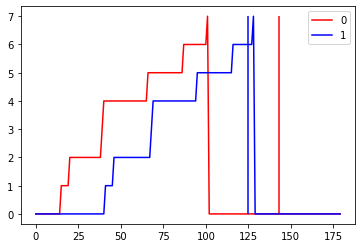

| 1         | -41.19    | 343.4     | 214.1     | 400.0     |


100%|██████████| 180/180 [00:00<00:00, 477.05it/s]


obs [143 125] sim [ 79 106]


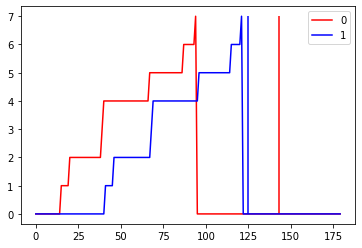

| 2         | -47.21    | 320.5     | 99.35     | 418.5     |


100%|██████████| 180/180 [00:00<00:00, 501.60it/s]


obs [143 125] sim [ 83 111]


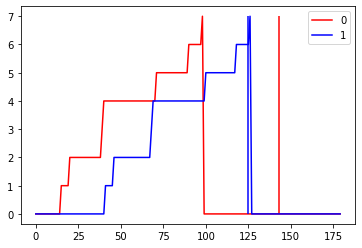

| 3         | -43.57    | 297.3     | 139.1     | 479.4     |


100%|██████████| 180/180 [00:00<00:00, 537.01it/s]


obs [143 125] sim [ 92 118]


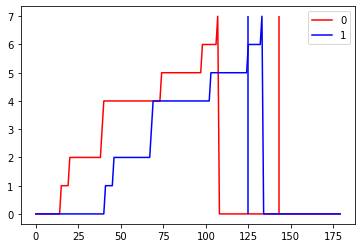

| 4         | -36.4     | 367.8     | 153.8     | 537.0     |


100%|██████████| 180/180 [00:00<00:00, 505.47it/s]


obs [143 125] sim [ 86 113]


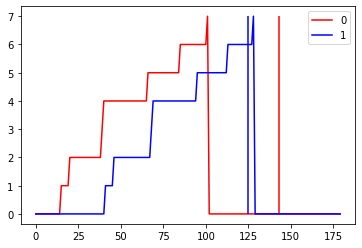

| 5         | -41.19    | 300.9     | 245.6     | 405.5     |


100%|██████████| 180/180 [00:00<00:00, 528.58it/s]


obs [143 125] sim [ 92 119]


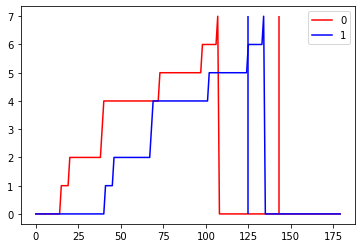

| 6         | -36.31    | 394.1     | 153.5     | 511.7     |


100%|██████████| 180/180 [00:00<00:00, 507.23it/s]


obs [143 125] sim [ 86 113]


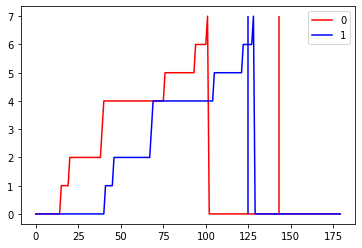

| 7         | -41.19    | 288.1     | 109.6     | 560.1     |


100%|██████████| 180/180 [00:00<00:00, 493.55it/s]


obs [143 125] sim [ 96 122]


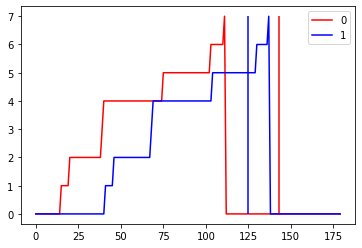

| 8         | -33.3     | 453.7     | 132.7     | 538.5     |


100%|██████████| 180/180 [00:00<00:00, 543.96it/s]


obs [143 125] sim [ 94 121]


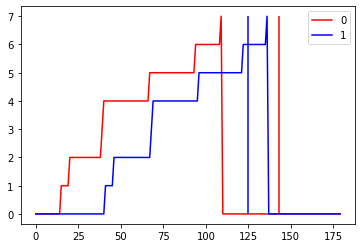

| 9         | -34.76    | 435.3     | 248.9     | 417.0     |


100%|██████████| 180/180 [00:00<00:00, 499.40it/s]


obs [143 125] sim [ 85 112]


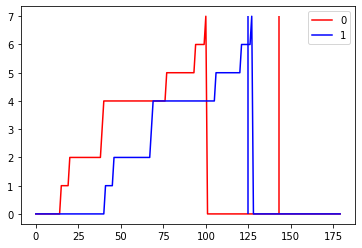

| 10        | -42.03    | 267.8     | 104.0     | 575.6     |


100%|██████████| 180/180 [00:00<00:00, 518.22it/s]


obs [143 125] sim [ 90 117]


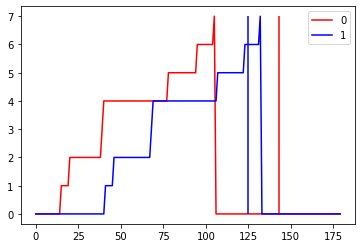

| 11        | -37.9     | 279.7     | 154.2     | 591.6     |


100%|██████████| 180/180 [00:00<00:00, 495.10it/s]


obs [143 125] sim [ 91 117]


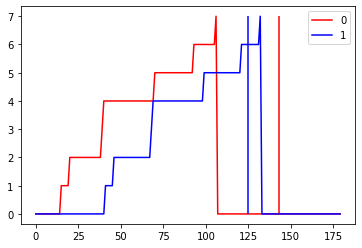

| 12        | -37.2     | 366.6     | 208.4     | 463.1     |


100%|██████████| 180/180 [00:00<00:00, 469.22it/s]


obs [143 125] sim [ 91 117]


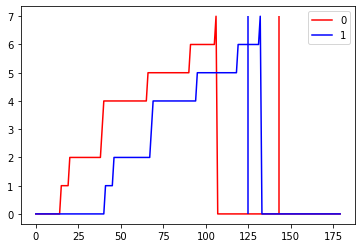

| 13        | -37.2     | 397.3     | 236.9     | 403.7     |


100%|██████████| 180/180 [00:00<00:00, 416.07it/s]


obs [143 125] sim [102 128]


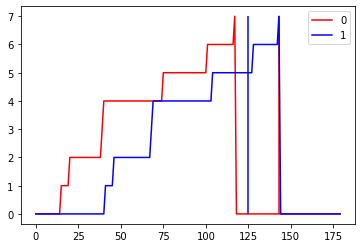

| 14        | -29.07    | 410.0     | 267.8     | 549.6     |


100%|██████████| 180/180 [00:00<00:00, 511.02it/s]


obs [143 125] sim [ 86 113]


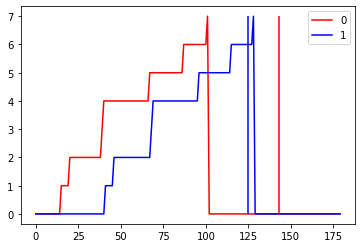

| 15        | -41.19    | 316.1     | 227.9     | 420.6     |


100%|██████████| 180/180 [00:00<00:00, 504.51it/s]


obs [143 125] sim [ 92 119]


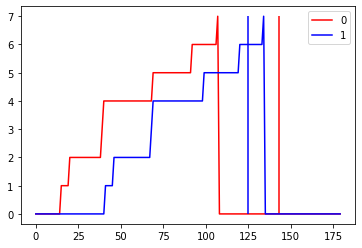

| 16        | -36.31    | 349.6     | 251.7     | 458.7     |


100%|██████████| 180/180 [00:00<00:00, 489.64it/s]


obs [143 125] sim [ 77 105]


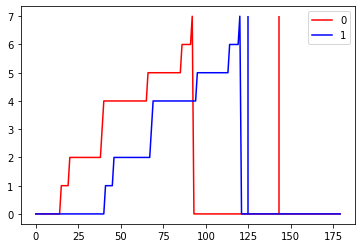

| 17        | -48.76    | 317.6     | 96.01     | 403.9     |


100%|██████████| 180/180 [00:00<00:00, 512.51it/s]


obs [143 125] sim [ 86 113]


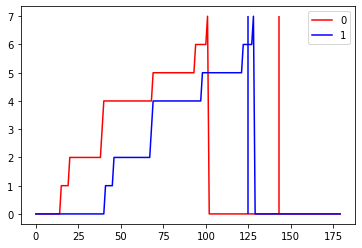

| 18        | -41.19    | 395.8     | 112.3     | 453.1     |


100%|██████████| 180/180 [00:00<00:00, 524.06it/s]


obs [143 125] sim [ 86 113]


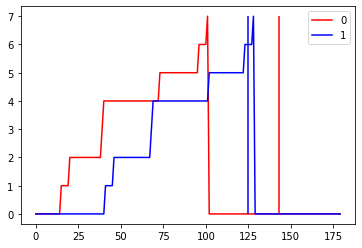

| 19        | -41.19    | 358.3     | 80.67     | 514.8     |


100%|██████████| 180/180 [00:00<00:00, 520.35it/s]


obs [143 125] sim [ 90 116]


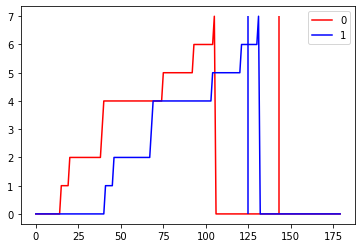

| 20        | -38.01    | 289.3     | 187.9     | 540.0     |


100%|██████████| 180/180 [00:00<00:00, 496.17it/s]


obs [143 125] sim [108 134]


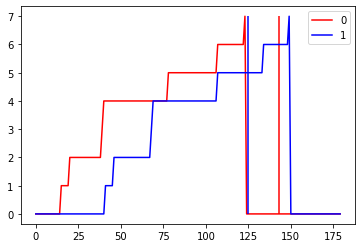

| 21        | -25.55    | 460.0     | 270.0     | 600.0     |


100%|██████████| 180/180 [00:00<00:00, 485.13it/s]


obs [143 125] sim [ 91 117]


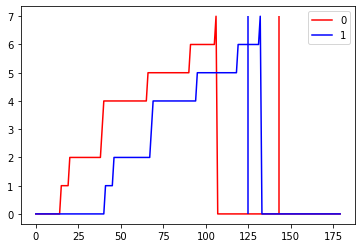

| 22        | -37.2     | 395.8     | 236.4     | 405.0     |


100%|██████████| 180/180 [00:00<00:00, 532.90it/s]


obs [143 125] sim [105 132]


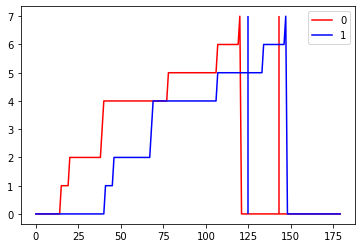

| 23        | -27.32    | 460.0     | 224.7     | 600.0     |


100%|██████████| 180/180 [00:00<00:00, 518.31it/s]


obs [143 125] sim [106 132]


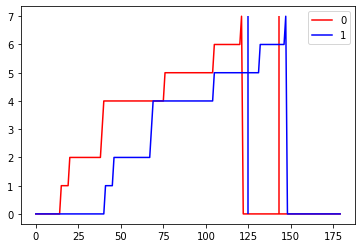

| 24        | -26.63    | 460.0     | 270.0     | 564.4     |


100%|██████████| 180/180 [00:00<00:00, 526.21it/s]


obs [143 125] sim [107 133]


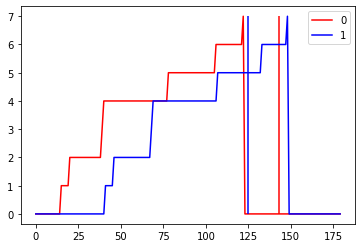

| 25        | -26.08    | 445.1     | 270.0     | 600.0     |
| 26        | -26.08    | 445.1     | 270.0     | 600.0     |
| 27        | -26.08    | 445.1     | 270.0     | 600.0     |
| 28        | -26.08    | 445.1     | 270.0     | 600.0     |
| 29        | -26.08    | 445.1     | 270.0     | 600.0     |
| 30        | -26.08    | 445.1     | 270.0     | 600.0     |
| 31        | -26.08    | 445.1     | 270.0     | 600.0     |
| 32        | -26.08    | 445.1     | 270.0     | 600.0     |
| 33        | -26.08    | 445.1     | 270.0     | 600.0     |
| 34        | -26.08    | 445.1     | 270.0     | 600.0     |
| 35        | -26.08    | 445.1     | 270.0     | 600.0     |
| 36        | -26.08    | 445.1     | 270.0     | 600.0     |
| 37        | -26.08    | 445.1     | 270.0     | 600.0     |
| 38        | -26.08    | 445.1     | 270.0     | 600.0     |
| 39        | -26.08    | 445.1     | 270.0     | 600.0     |
| 40        | -26.08    | 445.1     | 270.0     | 600.0     |
| 41    

In [97]:
optimizer.maximize(init_points=20, n_iter=60)

In [98]:
optimizer.max

{'target': -25.553864678361276,
 'params': {'SDJMatu1': 460.0, 'SDJMatu2': 270.0, 'SDJRPR': 600.0}}

In [99]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [100]:
interact(run, SDJRPR=500, SDJMatu1=360, SDJMatu2=170)

interactive(children=(IntSlider(value=500, description='SDJRPR', max=1500, min=-500), IntSlider(value=360, des…

<function __main__.run(SDJRPR, SDJMatu1, SDJMatu2)>